In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm import LightFM
from scipy.sparse import coo_matrix
from scipy import sparse

# Read data and basic facts about df

In [167]:
hike_data = pd.read_pickle('../data/all_hike_data')

In [5]:
hike_data.head(1)

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates
0,Taft Point and The Fissures - California\n |...,EASY,2.3 miles,374 feet,Out & Back,"[kid friendly, birding, hiking, horseback ridi...",Taft Point and The Fissures is a 2.3 mile mode...,"[Soua Lee, Jeff Allen, Nicole Edmonds, Marie K...","[/members/soua-lee-3, /members/jeff-allen-41, ...",[Incredible hike! I would do this again althou...,"[5, 4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[2018-11-13 00:00:00, 2018-11-05 00:00:00, 201..."


In [7]:
hrefs = pd.Series(hike_data['user_hrefs'].sum())

In [58]:
print(str(hike_data.shape[0]) + ' hikes')
print(str(len(hrefs.unique())) + ' unique users')
print(str((hrefs.isnull() == False).sum()) + ' text reviews.')

sparsity = 226618 / (5367*105535) * 100
print('sparsity = ' + str(sparsity))

5367 hikes
105535 unique users
226618 text reviews.
sparsity = 0.0400097919100818


In [451]:
len(hrefs)

240346

# Correct hike names

In [46]:
def correct_hike_names(df):
    df['hike_name'] = df['hike_name'].str.replace('\n', '').str.replace('- California \| AllTrails', '').str.strip()

In [168]:
correct_hike_names(hike_data)

In [169]:
hike_data.head(1)

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates
0,Taft Point and The Fissures,EASY,2.3 miles,374 feet,Out & Back,"[kid friendly, birding, hiking, horseback ridi...",Taft Point and The Fissures is a 2.3 mile mode...,"[Soua Lee, Jeff Allen, Nicole Edmonds, Marie K...","[/members/soua-lee-3, /members/jeff-allen-41, ...",[Incredible hike! I would do this again althou...,"[5, 4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[2018-11-13 00:00:00, 2018-11-05 00:00:00, 201..."


# Make matrix for collab filt

In [172]:
def gen_collabfilt_matrix(df):

    hike_user_rating_dict = {}
    for hike_index in range(df.shape[0]):
        hike_name = df.loc[hike_index, 'hike_name']
        user_names = df.loc[hike_index, 'user_names']
        user_ratings = df.loc[hike_index, 'user_ratings']
        
        user_rating_dict = {}
        for user_index in range(len(user_names)):
            user_rating_dict[user_names[user_index]] = user_ratings[user_index]
        
        hike_user_rating_dict[hike_name] = user_rating_dict
    
    return pd.DataFrame(hike_user_rating_dict, dtype='int')

In [173]:
hike_user_rating_matrix = gen_collabfilt_matrix(hike_data)

In [189]:
def convert_to_binary(df, cutoff):
    df = df.fillna(0)
    df[df < cutoff] = 0
    df[df > cutoff] = 1
    
    return df

In [204]:
hike_user_rating_matrix_bool = convert_to_binary(hike_user_rating_matrix, 3.5)

In [208]:
# filter if user has less than 10 reviews
hike_user_rating_matrix_bool_filtered = hike_user_rating_matrix_bool[hike_user_rating_matrix_bool.apply(np.sum, axis=1) > 10]

In [278]:
def get_basic_stats(df):

    num_users = df.shape[0]
    num_hikes = df.shape[1]
    num_ratings = df.values.sum()
    sparsity = num_ratings / (num_hikes * num_users) * 100

    print('Number of hikes: ' + str(num_hikes))
    print('Number of users: ' + str(num_users))
    print('Number of ratings: {:.0f}'.format(num_ratings))
    print('Sparsity = {:4.2f}%'.format(sparsity))

In [279]:
get_basic_stats(hike_user_rating_matrix_bool_filtered)

Number of hikes: 5295
Number of users: 1374
Number of ratings: 24485
Sparsity = 0.34%


In [449]:
'{:.2f}%'.format(24485 / 226618 * 100)

'10.80%'

In [228]:
# filter if hike has no ratings
hike_user_rating_matrix_bool_filtered2 = hike_user_rating_matrix_bool_filtered.loc[:, (hike_user_rating_matrix_bool_filtered != 0).any(axis=0)]

In [280]:
get_basic_stats(hike_user_rating_matrix_bool_filtered2)

Number of hikes: 3606
Number of users: 1374
Number of ratings: 24485
Sparsity = 0.49%


In [448]:
'{:.2f}%'.format(24485 / 226618 * 100)

'10.80%'

In [ ]:
# filter if hike has less than 10 ratings

In [238]:
hike_user_rating_matrix_bool_filtered3 = hike_user_rating_matrix_bool_filtered2.loc[:, hike_user_rating_matrix_bool_filtered2.apply(np.sum, axis=0) > 10]

In [281]:
get_basic_stats(hike_user_rating_matrix_bool_filtered3)

Number of hikes: 616
Number of users: 1374
Number of ratings: 15288
Sparsity = 1.81%


In [447]:
'{:.2f}%'.format(15288 / 226618 * 100)

'6.75%'

In [452]:
hike_user_rating_matrix_bool_filtered3.head(5)

,Taft Point and The Fissures,Aliso Creek and Wood Canyon Loop Trail,Upper Natural Bridge Trail,Lake Miramar Trail,San Antonio Falls Trail,The Slot,Panoramic Hill - Chaparral Peak - Strawberry Canyon Loop,Lafayette Reservoir Nature Area Rim Trail,Cleo's Bath Trail via Pinecrest Lake Loop,Devil's Slide to Saddle Junction Trail,...,Rae Lakes Trail,Congress Trail,Strawberry Canyon Fire Trail,Annie's Canyon via North Rios Trail,Lake Margaret Trail,Deep Creek Hot Springs Trail,Cougar Crest Trail,Abalone Cove Trail,"Torrey Pines - Red Butte, Yucca Point, and Razor Point",Soberanes Canyon Trail
Bill Friedman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$15 $40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
** watson **,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3IrinaAmira D.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@rafiky _resiii,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
def matrix_map(df):
    row_map = {}
    for index, name in enumerate(df.index):
        row_map[index] = name
        
    col_map = {}
    for index, name in enumerate(df.columns):
        col_map[index] = name
        
    return row_map, col_map

In [461]:
row_map, col_map = matrix_map(hike_user_rating_matrix_bool_filtered3)

In [567]:
hike_matrix_sparse = sparse.csr_matrix(hike_user_rating_matrix_bool_filtered3)

In [570]:
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [571]:
train, test, user_index = train_test_split(hike_matrix_sparse, 5, fraction=0.2)

In [572]:
# Set the number of threads; you can increase this
# ify you have more physical cores available.
NUM_THREADS = 1
NUM_COMPONENTS = 30
NUM_EPOCHS = 5
ITEM_ALPHA = 1e-6

# Let's fit a WARP model: these generally have the best performance.
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model = model.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 161 ms, sys: 3.68 ms, total: 164 ms
Wall time: 164 ms


In [578]:
# Import the evaluation routines
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.8957023


In [575]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model, test, train_interactions=train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.84853935


In [581]:
precision_at_k(model, test, train_interactions=train, k=10).mean()

0.11058395

# Visualizations

Distribution of Ratings

In [252]:
from collections import Counter

In [248]:
rating_list = hike_data['user_ratings'].sum()

In [257]:
rating_list_counter = Counter(rating_list)

In [265]:
ratings_values, ratings_count = rating_list_counter.keys(), rating_list_counter.values()

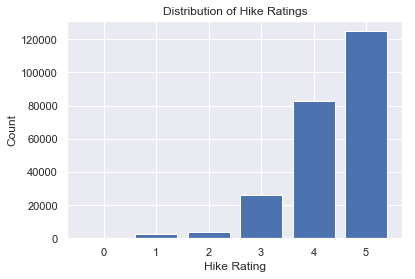

In [277]:
sns.set()
plt.bar(ratings_values, ratings_count)
plt.xlabel('Hike Rating')
plt.ylabel('Count')
plt.title('Distribution of Hike Ratings');

Number of ratings

In [240]:
rated_or_not = convert_to_binary(hike_user_rating_matrix, 0.5)

In [246]:
rated = rated_or_not.values.sum()
not_rated = rated_or_not.shape[0] * rated_or_not.shape[1] - rated

print('Number of ratings: ' + str(int(rated)) + '.')
print('Number of no-ratings ' + str(int(not_rated)) + '.')

Number of ratings: 222987.
Number of no-ratings 552755043.


# Text data

In [442]:
import string
import re
import spacy
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
punctuation = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanheinze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [410]:
example = ' '.join(hike_data.loc[0, 'user_texts'])
example = re.sub("""[{}]""".format(punctuation), '', example) # get rid of punctuation
example = re.sub('\s{2,10}', ' ', example) # remove extra whitespace
example = example.lower() # make lower case

In [412]:
example[:100]

'incredible hike i would do this again although i wouldnt try to be daring due to the recent death th'

In [414]:
example_words = gensim.utils.simple_preprocess(example, deacc=True)

In [417]:
def remove_stopwords(word_list):
    #return [[word for word in example_words if word not in stop_words] for doc in texts]
    return [ word for word in word_list if word not in stop_words ]

In [418]:
example_words_filt = remove_stopwords(example_words)

In [438]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(string, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = [] 
    texts_out.append([token.lemma_ for token in nlp(string) if token.pos_ in allowed_postags])
    
    return texts_out

In [440]:
lemmatized = lemmatization(' '.join(example_words_filt))

In [441]:
lemmatized[:10]

[['incredible',
  'hike',
  'would',
  'would',
  'not',
  'try',
  'dare',
  'due',
  'recent',
  'death',
  'news',
  'indian',
  'couple',
  'vishnu',
  'viswanath',
  'meenakshi',
  'moorthy',
  'october',
  'think',
  'back',
  'even',
  'walk',
  'fissure',
  'seem',
  'solid',
  'grounding',
  'rock',
  'would',
  'attempt',
  'place',
  'remarkable',
  'spend',
  'hour',
  'take',
  'photo',
  'nice',
  'little',
  'hike',
  'road',
  'first',
  'drive',
  'hour',
  'yosemite',
  'good',
  'way',
  'start',
  'great',
  'weekend',
  'slightly',
  'mile',
  'way',
  'carry',
  'bottle',
  'water',
  'really',
  'hill',
  'hill',
  'trail',
  'flat',
  'small',
  'section',
  'go',
  'slightly',
  'get',
  'close',
  'edge',
  'last',
  'foot',
  'trail',
  'downhill',
  'get',
  'point',
  'fissure',
  'east',
  'right',
  'hand',
  'side',
  'take',
  'little',
  'time',
  'view',
  'make',
  'way',
  'point',
  'point',
  'find',
  'look',
  'east',
  'old',
  'guard',
  'rail